## Imports

In [1]:
import os
import sys
import scipy
import datetime

In [2]:
sys.path.append(os.path.join(os.pardir, 'src'))

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
from tqdm.notebook import tqdm
from collections import defaultdict

In [6]:
from CBO.distributions import Normal
from CBO.functions import rastrigin, rastrigin_c, square
from CBO.minimize import minimize
from CBO.visualizations import visualize_trajectory_convergence
from CBO.train import train, NeuralNetworkObjectiveFunction, TensorboardLogging, compute_model_dimensionality

## Data preparation

In [7]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def load_mnist_data():
    (X_train, y_train),(X_test, y_test) = mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_mnist_data()

## Model training

In [9]:
def build_default_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])

In [10]:
def build_small_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(10),
    ])

In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
! rm -rf logs/fit

In [13]:
def conduct_tf_training(model, X_train, X_test, y_train, y_test, with_tensorboard=False,
                        model_description='', epoches=10):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    if with_tensorboard:
        log_dir = 'logs/fit/' + model_description
        if model_description is '':
            log_dir += datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test),
                  callbacks=[tensorboard_callback])
    else:
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test))
    
    return model

In [14]:
tensorboard_logging = TensorboardLogging('cbo_small', 'logs/fit')

In [ ]:
cbo_small_model, trajectory = train(build_small_model(), loss, X_train, y_train, n_particles=100, 
                                    time_horizon=12,
                                    optimizer_config = {'alpha': 50, 'sigma': 0.4**0.5, 'dt': 0.1}, 
                                    initial_distribution=Normal(0, 1),
                                    return_trajectory=True, verbose=True, particles_batches=10, 
                                    dataset_batches=60, X_val=X_test, y_val=y_test, 
                                    tensorboard_logging=tensorboard_logging)

In [ ]:
adam_small_model = conduct_tf_training(build_small_model(),
                                       X_train, X_test, y_train, y_test,
                                       with_tensorboard=True,
                                       model_description='adam_small', epoches=20)

## Results analysis

In [19]:
all_weights = np.concatenate([tf.reshape(w, -1).numpy() for w in adam_small_model.trainable_weights])

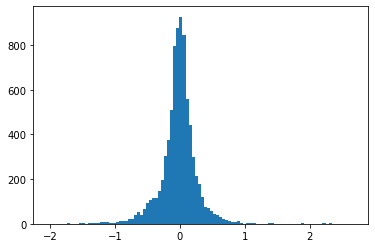

In [20]:
plt.clf()
plt.hist(all_weights, bins=100)
plt.show()

In [132]:
def update_model_parameters(model, parameters):
    current_position = 0
    for weight in model.trainable_weights:
        next_position = current_position + tf.size(weight)
        weight.assign(tf.reshape(parameters[current_position:next_position], weight.shape))
        current_position = next_position
    return model

def get_model_predictions(model, parameters, X):
    model = update_model_parameters(model, tf.reshape(parameters, -1))
    predictions = model(X).numpy()
    return np.argmax(predictions, axis=1)

def get_predictions_distribution(values):
    _, counts = np.unique(values, return_counts=True)
    return 1. * counts / counts.sum()

def plot_model_predictive_distribution(model, parameters, X, title=''):
    plt.clf()
    plt.xticks(range(10))
    plt.xlim((0, 10))
    plt.title(title)
    predictions, counts = np.unique(get_model_predictions(model, parameters, X),
                                    return_counts=True)
    plt.bar(x=predictions + 0.5, height=1.*counts/counts.sum(), width=1)
    plt.xlabel('prediction')
    plt.ylabel('density')
    plt.show()

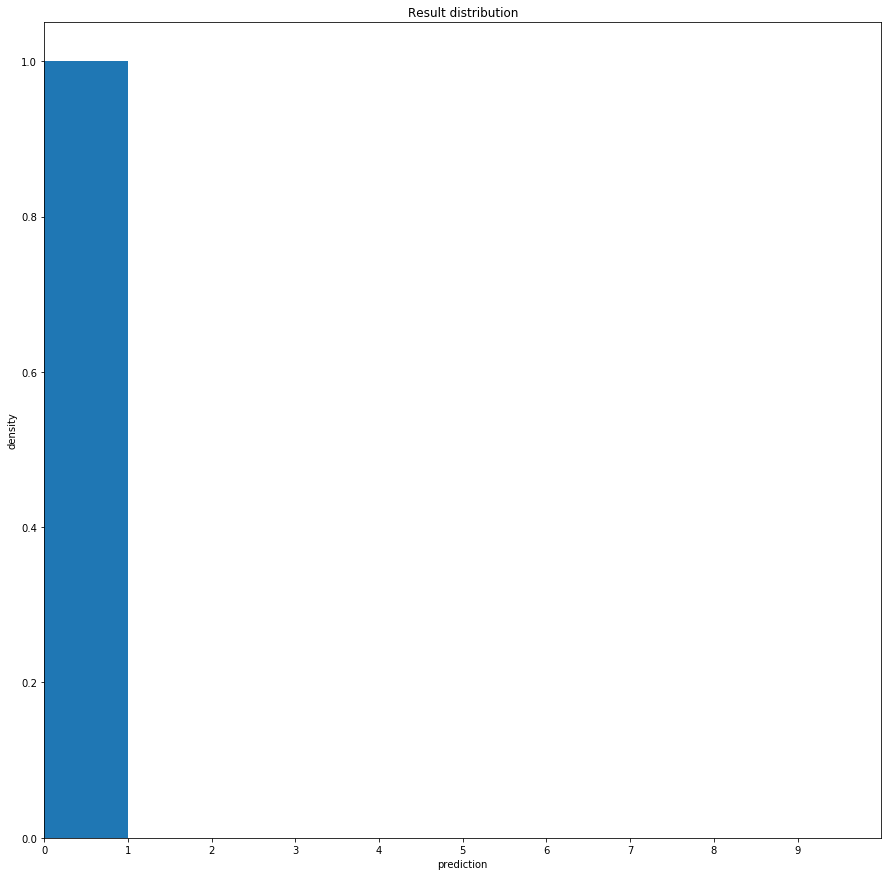

In [133]:
last_timestamp = list(sorted(trajectory.keys()))[-1]
plot_model_predictive_distribution(build_small_model(),
                                   trajectory[last_timestamp]['consensus'],
                                   X_test, 'Result distribution')

In [140]:
def plot_particles_entropy(model, trajectoty, X, n_particles=10, logarithmic=False):
    overall_particles = len(trajectory[0]['particles'])
    particles = list(sorted(np.random.choice(overall_particles, n_particles, replace=False)))
    entropy = defaultdict(lambda: [])
    timestamps = list(sorted(trajectoty.keys()))
    for timestamp in tqdm(timestamps):
        for particle in particles:
            predictions = get_model_predictions(model, trajectoty[timestamp]['particles'][particle], X)
            entropy[particle].append(scipy.stats.entropy(get_predictions_distribution(predictions)))
    plt.clf()
    plt.rcParams['figure.figsize'] = (15, 15)
    for particle, particle_entropy in entropy.items():
        plt.plot(timestamps, np.log(particle_entropy) if logarithmic else particle_entropy, 
                 label=f'particle {particle}')
    plt.xlabel('Timestamp')
    plt.ylabel('Predictive distribution entropy')
    plt.legend()
    plt.show()

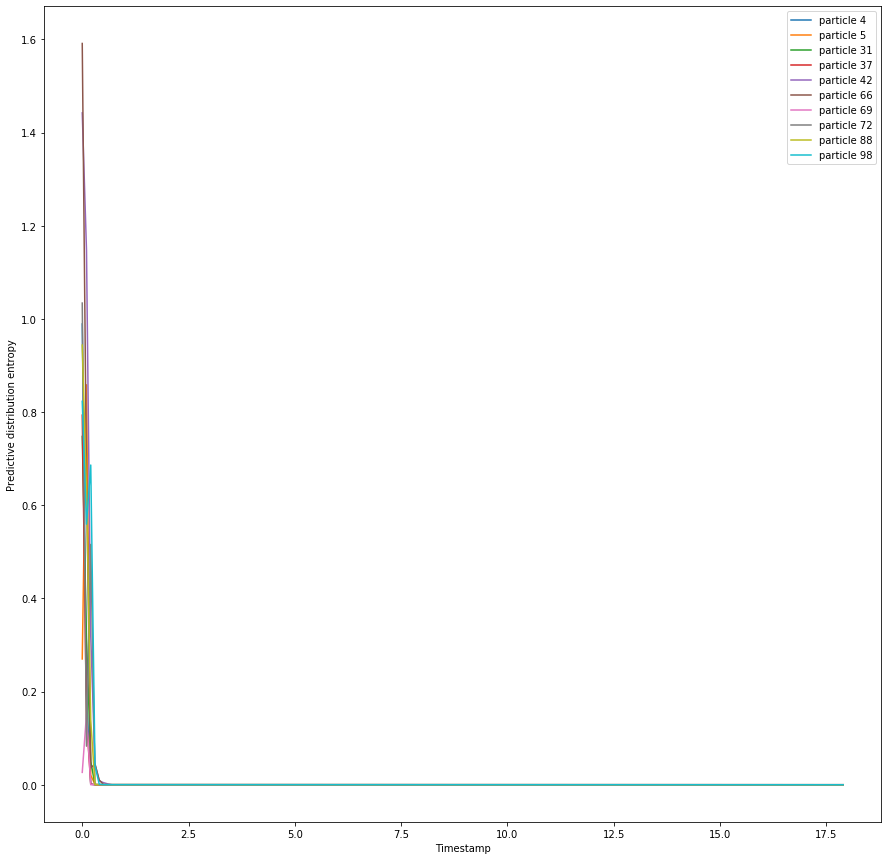

In [142]:
plot_particles_entropy(build_small_model(), trajectory, X_train)

In [ ]:
def visualize_particle_path_1d(trajectory, particle_ind, projection_dimenssion):
    timestamps = list(sorted(list(trajectory.keys())))
    particle_positions = [trajectory[ts]['particles'][particle_ind][projection_dimenssion]
                          for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, particle_positions)
    plt.xlabel('Timestamp')
    plt.ylabel('Particle position')
    plt.show()
    
def visalize_particles_shift(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    shifts = []
    for ind, ts in enumerate(timestamps[:-1]):
        shifts.append(tf.norm(trajectory[ts]['particles'] - trajectory[timestamps[ind + 1]]['particles'],
                              ord='euclidean'))
    plt.clf()
    plt.plot(timestamps[1:], shifts)
    plt.xlabel('Timestamp')
    plt.ylabel('Shift')
    plt.show()
    
def visalize_particles_std(trajectory, logarithmic=False):
    timestamps = list(sorted(list(trajectory.keys())))
    stds = []
    for ts in timestamps:
        stds.append(tf.math.reduce_std(trajectory[ts]['particles']))
    if logarithmic:
        stds = np.log(stds)
    plt.clf()
    plt.plot(timestamps, stds)
    plt.xlabel('Timestamp')
    plt.ylabel('Std')
    plt.show()

# contrains accuracies from different batches!
def visualize_cbo_accuracy(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    accuracies = [trajectory[ts]['accuracy'] for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, accuracies)
    plt.xlabel('Timestamp')
    plt.ylabel('Accuracy')
    plt.show()

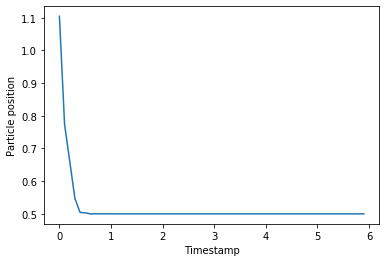

In [31]:
visualize_particle_path_1d(trajectory, 0, 0)

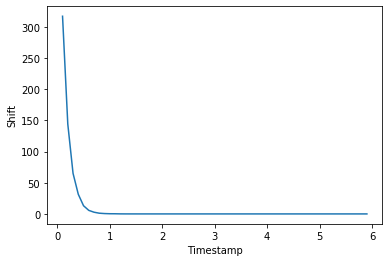

In [32]:
visalize_particles_shift(trajectory)

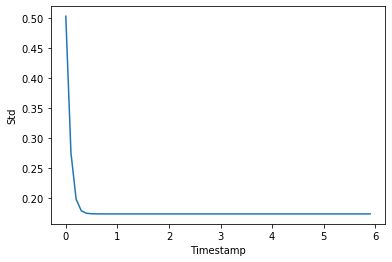

In [20]:
visalize_particles_std(trajectory)

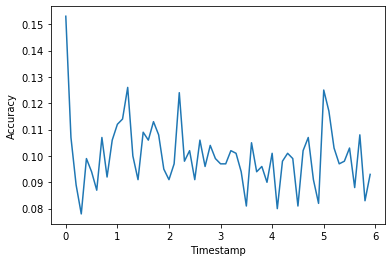

In [21]:
visualize_cbo_accuracy(trajectory)

## Random initialization leads to unbalanced predictions of the initial model!

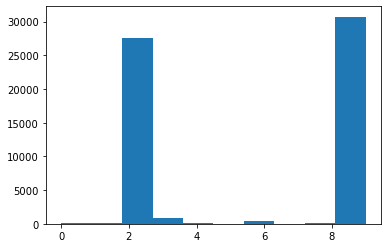

In [51]:
model = build_small_model()
initial_weights = tf.Variable(Normal(0, 1).sample(compute_model_dimensionality(model)))
model = update_model_parameters(model, initial_weights)
y_pred = np.argmax(tf.nn.softmax(model(X_train)), axis=1)
plt.hist(y_pred)
plt.show()